In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize']= 16,8
plt.style.use('seaborn-darkgrid')
import numpy as np
from datetime import datetime
import pandas as pd
import ruptures as rpt
import changefinder
from datetime import timedelta
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments

C:\Users\casos\AppData\Local\Continuum\anaconda2\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [5]:
def getPrices(p0_fini, p1_ffin, p2_gran, p3_inst, p4_oatk, p5_ginc):
    """
    Parameters
    ----------
    p0_fini
    p1_ffin
    p2_gran
    p3_inst
    p4_oatk
    p5_ginc
    Returns
    -------
    dc_precios
    Debugging
    ---------
    """

    def f_datetime_range_fx(p0_start, p1_end, p2_inc, p3_delta):
        """
        Parameters
        ----------
        p0_start
        p1_end
        p2_inc
        p3_delta
        Returns
        -------
        ls_resultado
        Debugging
        ---------
        """

        ls_result = []
        nxt = p0_start

        while nxt <= p1_end:
            ls_result.append(nxt)
            if p3_delta == 'minutes':
                nxt += timedelta(minutes=p2_inc)
            elif p3_delta == 'hours':
                nxt += timedelta(hours=p2_inc)
            elif p3_delta == 'days':
                nxt += timedelta(days=p2_inc)

        return ls_result

    # inicializar api de OANDA

    api = API(access_token=p4_oatk)

    gn = {'S30': 30, 'S10': 10, 'S5': 5, 'M1': 60, 'M5': 60 * 5, 'M15': 60 * 15,
          'M30': 60 * 30, 'H1': 60 * 60, 'H4': 60 * 60 * 4, 'H8': 60 * 60 * 8,
          'D': 60 * 60 * 24, 'W': 60 * 60 * 24 * 7, 'M': 60 * 60 * 24 * 7 * 4}

    # -- para el caso donde con 1 peticion se cubran las 2 fechas
    if int((p1_ffin - p0_fini).total_seconds() / gn[p2_gran]) < 4999:

        # Fecha inicial y fecha final
        f1 = p0_fini.strftime('%Y-%m-%dT%H:%M:%S')
        f2 = p1_ffin.strftime('%Y-%m-%dT%H:%M:%S')

        # Parametros pra la peticion de precios
        params = {"granularity": p2_gran, "price": "M", "dailyAlignment": 16, "from": f1,
                  "to": f2}

        # Ejecutar la peticion de precios
        a1_req1 = instruments.InstrumentsCandles(instrument=p3_inst, params=params)
        a1_hist = api.request(a1_req1)

        # Para debuging
        # print(f1 + ' y ' + f2)
        lista = list()

        # Acomodar las llaves
        for i in range(len(a1_hist['candles']) - 1):
            lista.append({'TimeStamp': a1_hist['candles'][i]['time'],
                          'Open': a1_hist['candles'][i]['mid']['o'],
                          'High': a1_hist['candles'][i]['mid']['h'],
                          'Low': a1_hist['candles'][i]['mid']['l'],
                          'Close': a1_hist['candles'][i]['mid']['c']})

        # Acomodar en un data frame
        r_df_final = pd.DataFrame(lista)
        r_df_final = r_df_final[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
        r_df_final['TimeStamp'] = pd.to_datetime(r_df_final['TimeStamp'])

        return r_df_final

    # -- para el caso donde se construyen fechas secuenciales
    else:

        # hacer series de fechas e iteraciones para pedir todos los precios
        fechas = f_datetime_range_fx(p0_start=p0_fini, p1_end=p1_ffin, p2_inc=p5_ginc,
                                     p3_delta='minutes')

        # Lista para ir guardando los data frames
        lista_df = list()

        for n_fecha in range(0, len(fechas) - 1):

            # Fecha inicial y fecha final
            f1 = fechas[n_fecha].strftime('%Y-%m-%dT%H:%M:%S')
            f2 = fechas[n_fecha + 1].strftime('%Y-%m-%dT%H:%M:%S')

            # Parametros pra la peticion de precios
            params = {"granularity": p2_gran, "price": "M", "dailyAlignment": 16, "from": f1,
                      "to": f2}

            # Ejecutar la peticion de precios
            a1_req1 = instruments.InstrumentsCandles(instrument=p3_inst, params=params)
            a1_hist = api.request(a1_req1)

            # Para debuging
            print(f1 + ' y ' + f2)
            lista = list()

            # Acomodar las llaves
            for i in range(len(a1_hist['candles']) - 1):
                lista.append({'TimeStamp': a1_hist['candles'][i]['time'],
                              'Open': a1_hist['candles'][i]['mid']['o'],
                              'High': a1_hist['candles'][i]['mid']['h'],
                              'Low': a1_hist['candles'][i]['mid']['l'],
                              'Close': a1_hist['candles'][i]['mid']['c']})

            # Acomodar en un data frame
            pd_hist = pd.DataFrame(lista)
            pd_hist = pd_hist[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
            pd_hist['TimeStamp'] = pd.to_datetime(pd_hist['TimeStamp'])

            # Ir guardando resultados en una lista
            lista_df.append(pd_hist)

        # Concatenar todas las listas
        r_df_final = pd.concat([lista_df[i] for i in range(0, len(lista_df))])

        # resetear index en dataframe resultante porque guarda los indices del dataframe pasado
        r_df_final = r_df_final.reset_index(drop=True)

        return r_df_final


def getReturns(data):
    """
    :param data: pandas dataframe containing OHLC prices
    """
    return np.log(data / data.shift(1)).iloc[1:]


def setTag(data):
    """
    :param data : pandas dataframe containing OHLC prices
    """
    direction = lambda open, close: 1 if open > close else 0
    data["Tag"] = list(direction(data["Open"][i], data["Close"][i]) for i in range(len(data)))
    return data

In [71]:
instrumento = "EUR_USD"
granularidad = "D"

f_inicio = pd.to_datetime("2017-01-01 17:00:00").tz_localize('GMT')
f_fin = pd.to_datetime("2020-10-22 17:00:00").tz_localize('GMT')
token = '40a4858c00646a218d055374c2950239-f520f4a80719d9749cc020ddb5188887'

df_pe= getPrices(p0_fini=f_inicio, p1_ffin=f_fin, p2_gran="D",
                            p3_inst=instrumento,p4_oatk=token, p5_ginc=4900)

In [72]:
df_pe = df_pe.set_index('TimeStamp')

for col in df_pe:
    for i in range(len(df_pe[col])):
        df_pe[col][i] = float(df_pe[col][i])

In [256]:
def window(data):
    '''
    data: Valores del activo EURUSD.
    
    '''
    data = np.array(data.Close) #De los datos del activo, selecciona la columna Close y la hace un array.
    
    n = len(data) #Tamaño de el array de datos.
    sigma = data.std() #Desviación estandar de los datos.
    p = np.log(n)*sigma**2 #Penalización que tiene el modelo.
    
    #Pasos a realizar para el metodo de window-based.
    algo = rpt.Window(width=32, jump=24).fit(data)
    my_bkps = algo.predict(pen=p)
    senal = pd.DataFrame(my_bkps)
    
    mean = np.array(senal) #Datos generados del metodo, traidos a un array.
    mean = mean.drop(len(my_bkps)-1) #Quitamos de la serie el último valor ya que no es correcto. 
    changes = mean.astype(int) #Hacer que el array contenga solo valores numericos enteros.
    
    fecha = [] #Lista vacia para introducir fechas donde el cambio ocurrio.
    #For para introducir los valores de la fechas en donde ocurrieron los changepoints.
    for i in range (0, len(my_bkps)-1):
        fecha += df_pe.index[changes[i]]
    
    #La función regresa las fechas y los valores numericos en donde ocurrieron los cambios.
    return fecha, changes

In [257]:
w = window(data, 1)
w

([Timestamp('2017-04-24 20:00:00+0000', tz='UTC'),
  Timestamp('2017-07-17 20:00:00+0000', tz='UTC'),
  Timestamp('2018-01-03 21:00:00+0000', tz='UTC'),
  Timestamp('2018-04-25 20:00:00+0000', tz='UTC'),
  Timestamp('2018-10-10 20:00:00+0000', tz='UTC'),
  Timestamp('2019-07-17 20:00:00+0000', tz='UTC'),
  Timestamp('2019-10-09 20:00:00+0000', tz='UTC'),
  Timestamp('2020-02-26 21:00:00+0000', tz='UTC'),
  Timestamp('2020-05-20 20:00:00+0000', tz='UTC'),
  Timestamp('2020-07-15 20:00:00+0000', tz='UTC')],
 array([[  96],
        [ 168],
        [ 312],
        [ 408],
        [ 552],
        [ 792],
        [ 864],
        [ 984],
        [1056],
        [1104],
        [1189]]))

In [268]:
def graph_changepoint(data, changes):
    '''
    data: Información del activo EURUSD.
    changes: Variable obtenida de algún modelo de change point. 
    '''
    data = np.array(data.Close) #De los datos del activo, selecciona la columna Close y la hace un array.

    #Pasos para graficar la información obtenida del modelo y de los datos.
    #Esta función regresa una gráfica para hacer visuales los resultados obtenidos del modelo.
    plt.figure(figsize=(16,8))
    plt.title('Change points detected.', size=20)
    plt.plot(data, label='Close price' ,color='darkorange', alpha = 0.7)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    plt.xlabel('Días transcurridos desde 2001',size=20)
    plt.ylabel('Precios de cierre',size=20)
    plt.legend(loc='upper left', fontsize=(18))
    for i in range (len(changes)):
        plt.axvline(x=changes[i], ymin=0,ymax=1.6, color='dimgray', linestyle='--')

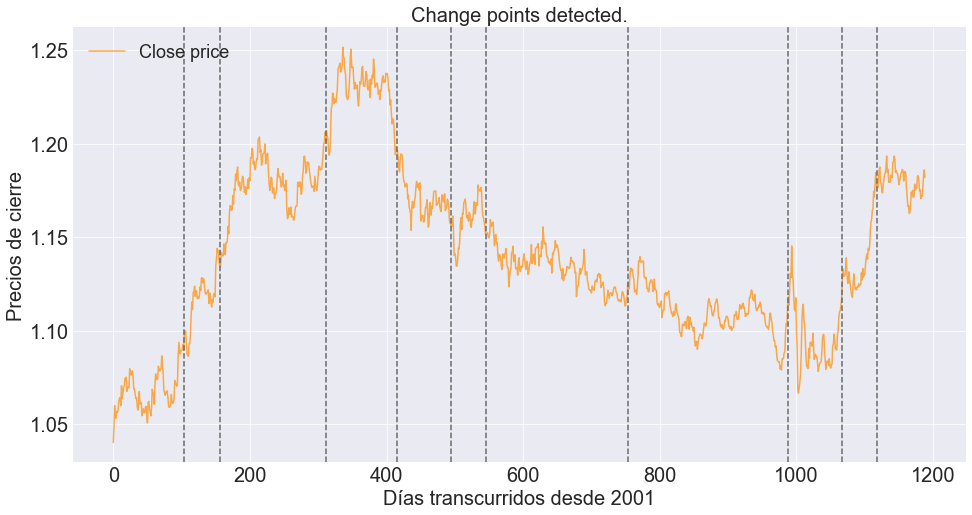

In [269]:
g = graph_changepoint(df_pe, changes)
g

In [265]:
def zerolistmaker(n):
    list_zeros = [0] * n #Multiplica 0's por la dimensión 'n'.

    #Regresa una lista de zeros de dimensión n.
    return list_zeros

def boolean_change_point(data, changes):
    
    data = np.array(data.Close) #De los datos del activo, selecciona la columna Close y la hace un array.
    #Uso de la función de 'zerolistmaker'.
    zero = zerolistmaker(len(data)) #Crea una lista de zeros del tamaño de tus datos.

    change = [int(x) for x in changes] #Cuenta cuantos cambios haras dentro de tu lista.
    
    #For para cambiar los datos en donde haya un cambio.
    for i in range (0, len(change)):
        zero[change[i]] = 1
        
    #Regresa una lista en donde se encuentran los cambios como 1 y los no cambios como 0. 
    return zero

In [267]:
x = boolean_change_point(df_pe, changes)
x

1189

In [260]:
def binary(data):
    '''
    data: Valores del activo EURUSD.
    
    '''
    data = np.array(data.Close) #De los datos del activo, selecciona la columna Close y la hace un array.
    
    n = len(data) #Tamaño de los datos dentro del array.
    sigma = data.std() #Desvación estandar de los datos.
    p = np.log(n)*sigma**2 #Penalización utilizada dentro del modelo.
    
    #Pasos a realizar dentro del modelo de Binary segmentation.
    algo = rpt.Binseg().fit(data)
    my_bkps = algo.predict(pen=p)
    senal = pd.DataFrame(my_bkps)

    mean = np.array(senal) #Valores obtenidos del modelo traidos a un array.
    mean = mean.drop(len(my_bkps)-1) #Quitamos de la serie el último valor ya que no es correcto.
    changes = mean.astype(int) #Valores del array anterior convertidos a numeros enteros.
    
    fecha = [] #Lista vacia para introducir fechas deseadas.
    #For para introducir las fechas en donde ocurrio un cambio.
    for i in range (0, len(my_bkps)-1):
        fecha += df_pe.index[changes[i]]
    
    #La función regresa las fechas y los cambios numericos. 
    return fecha, changes

In [261]:
b = binary(df_pe)
b

([Timestamp('2017-05-16 20:00:00+0000', tz='UTC'),
  Timestamp('2017-07-19 20:00:00+0000', tz='UTC'),
  Timestamp('2018-01-12 21:00:00+0000', tz='UTC'),
  Timestamp('2018-04-27 20:00:00+0000', tz='UTC'),
  Timestamp('2018-05-15 20:00:00+0000', tz='UTC'),
  Timestamp('2018-10-02 20:00:00+0000', tz='UTC'),
  Timestamp('2019-07-21 20:00:00+0000', tz='UTC'),
  Timestamp('2020-03-16 20:00:00+0000', tz='UTC'),
  Timestamp('2020-05-31 20:00:00+0000', tz='UTC'),
  Timestamp('2020-07-16 20:00:00+0000', tz='UTC')],
 array([[ 115],
        [ 170],
        [ 320],
        [ 410],
        [ 425],
        [ 545],
        [ 795],
        [1000],
        [1065],
        [1105],
        [1189]]))

In [283]:
dd = pd.DataFrame(df_pe.iloc[0:115])
dd

,Open,High,Low,Close
TimeStamp,,,,
2017-01-02 21:00:00+00:00,1.04684,1.04902,1.03406,1.04021
2017-01-03 21:00:00+00:00,1.04018,1.05,1.03899,1.04863
2017-01-04 21:00:00+00:00,1.0486,1.06153,1.04808,1.05992
2017-01-05 21:00:00+00:00,1.05994,1.06224,1.05251,1.05343
2017-01-06 21:00:00+00:00,1.0534,1.05354,1.053,1.05323
...,...,...,...,...
2017-05-10 20:00:00+00:00,1.08658,1.0893,1.08393,1.08636
2017-05-11 20:00:00+00:00,1.08634,1.09343,1.08557,1.093
2017-05-12 20:00:00+00:00,1.09297,1.0933,1.09272,1.09314


In [292]:
c = changes
c

array([[ 104],
       [ 156],
       [ 312],
       [ 416],
       [ 494],
       [ 546],
       [ 754],
       [ 988],
       [1066],
       [1118]])

In [300]:
c = [int(i) for i in c]

In [302]:
c[0]

104

In [316]:
def separacion_change(data, changes):
    c = changes
    c = [int(i) for i in c]
    
    datos0 = pd.DataFrame(data.iloc[0:c[0]])
    datos1 = pd.DataFrame(data.iloc[c[0]:c[1]])
    datos2 = pd.DataFrame(data.iloc[c[1]:c[2]])
    datos3 = pd.DataFrame(data.iloc[c[2]:c[3]])
    datos4 = pd.DataFrame(data.iloc[c[3]:c[4]])
    datos5 = pd.DataFrame(data.iloc[c[4]:c[5]])
    datos6 = pd.DataFrame(data.iloc[c[5]:c[6]])
    datos7 = pd.DataFrame(data.iloc[c[6]:c[7]])
    datos8 = pd.DataFrame(data.iloc[c[7]:c[8]])
    datos9 = pd.DataFrame(data.iloc[c[8]:c[9]])
    datos10 = pd.DataFrame(data.iloc[c[9]:len(data)])
    return datos0, datos1, datos2, datos3, datos4, datos5, datos6, datos7, datos8, datos9, datos10

In [317]:
sd = separacion_change(df_pe, changes)
sd

(                              Open     High      Low    Close
 TimeStamp                                                    
 2017-01-02 21:00:00+00:00  1.04684  1.04902  1.03406  1.04021
 2017-01-03 21:00:00+00:00  1.04018     1.05  1.03899  1.04863
 2017-01-04 21:00:00+00:00   1.0486  1.06153  1.04808  1.05992
 2017-01-05 21:00:00+00:00  1.05994  1.06224  1.05251  1.05343
 2017-01-06 21:00:00+00:00   1.0534  1.05354    1.053  1.05323
 ...                            ...      ...      ...      ...
 2017-04-27 20:00:00+00:00   1.0875  1.09472  1.08572  1.08932
 2017-04-28 20:00:00+00:00  1.08934  1.09003  1.08896  1.08962
 2017-04-30 20:00:00+00:00   1.0913  1.09238  1.08842  1.08984
 2017-05-01 20:00:00+00:00  1.08986  1.09304  1.08884   1.0926
 2017-05-02 20:00:00+00:00  1.09262  1.09368   1.0887  1.08954
 
 [104 rows x 4 columns],
                               Open     High      Low    Close
 TimeStamp                                                    
 2017-05-03 20:00:00+00:00  